In [1]:
import torch

In [2]:
ckp = torch.load("ckpts/cnn.ckpt")

In [3]:
from protoclr_obow import PCLROBoW

In [4]:
from omegaconf import OmegaConf
OmegaConf.register_resolver("uuid", lambda : "123")

/tmp/ipykernel_45429/2572628453.py:2: UserWarning: register_resolver() is deprecated.
See https://github.com/omry/omegaconf/issues/426 for migration instructions.

  OmegaConf.register_resolver("uuid", lambda : "123")


In [17]:
model = PCLROBoW.load_from_checkpoint("ckpts/cnn.ckpt").to("cuda")

MultiHeadDotProduct


/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [6]:
from dataloaders import UnlabelledDataset, UnlabelledDataModule

In [7]:
dm = UnlabelledDataModule(**OmegaConf.load("configs/local/edge.yml")["data"], split="train")
dm.setup()

In [8]:
dlt = dm.train_dataloader()

In [9]:
xs = next(iter(dlt))

In [10]:
o,v = xs["origs"], xs["views"]

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import einops
sns.set_theme()

In [12]:
o = einops.rearrange(o, "b 1 c h w -> b c h w")

In [13]:
v = einops.rearrange(v, "b q c h w -> (b q) c h w")

In [14]:
y_query = torch.arange(64).unsqueeze(
            0).unsqueeze(2)  # batch and shot dim
y_query = y_query.repeat(1, 1, 3)
y_query = y_query.view(1, -1).to("cuda")

y_support = torch.arange(64).unsqueeze(
    0).unsqueeze(2)  # batch and shot dim
y_support = y_support.repeat(1, 1, 1)
y_support = y_support.view(1, -1).to("cuda")

In [15]:
y = torch.cat([y_support, y_query], dim=1).squeeze(0)

In [18]:
feats = model.feature_extractor(torch.cat([o, v]).cuda())

In [19]:
feats = feats.flatten(1)

In [20]:
pfeats = umap.UMAP().fit_transform(feats.cpu().detach().numpy())

<AxesSubplot:>

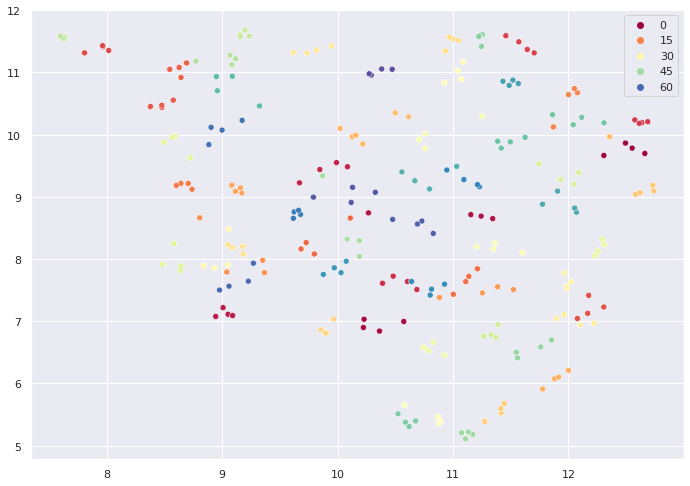

In [21]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=pfeats[:, 0], y=pfeats[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend=None)

In [22]:
edge_attr, edge_index, feats = model.graph_generator.get_graph(feats)

In [23]:
feats = model.gnn(feats, edge_index.cuda(), edge_attr.cuda(), ckp["hyper_parameters"]["mpnn_opts"]["output_train_gnn"])

In [24]:
gfeats = umap.UMAP().fit_transform(feats[1][0].cpu().detach().numpy())

<AxesSubplot:>

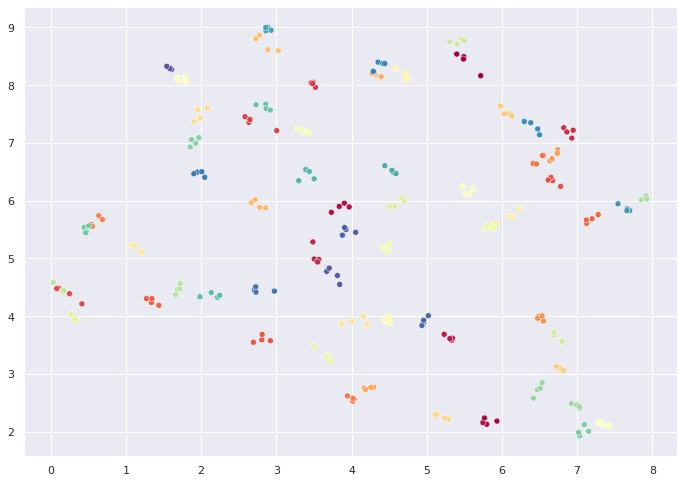

In [27]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=gfeats[:, 0], y=gfeats[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend=None)